# Package Setup

## Installations

In [1]:
!pip install umap-learn
!pip install sentence-transformers
!pip install pyvis
!pip install matplotlib
!pip install seaborn
!pip install branca


[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



  Obtaining dependency information for umap-learn from https://files.pythonhosted.org/packages/3c/8f/671c0e1f2572ba625cbcc1faeba9435e00330c3d6962858711445cf1e817/umap_learn-0.5.7-py3-none-any.whl.metadata
  Obtaining dependency information for numpy>=1.17 from https://files.pythonhosted.org/packages/fc/84/7f801a42a67b9772a883223a0a1e12069a14626c81a732bd70aac57aebc1/numpy-2.2.2-cp312-cp312-win_amd64.whl.metadata
  Using cached numpy-2.2.2-cp312-cp312-win_amd64.whl.metadata (60 kB)
  Obtaining dependency information for scipy>=1.3.1 from https://files.pythonhosted.org/packages/ff/ba/31c7a8131152822b3a2cdeba76398ffb404d81d640de98287d236da90c49/scipy-1.15.1-cp312-cp312-win_amd64.whl.metadata
  Using cached scipy-1.15.1-cp312-cp312-win_amd64.whl.metadata (60 kB)
  Obtaining dependency information for scikit-learn>=0.22 from https://files.pythonhosted.org/packages/62/27/585859e72e117fe861c2079bcba35591a84f801e21bc1ab85bce6ce60305/scikit_learn-1.6.1-cp312-cp312-win_amd64.whl.metadata
  Using


[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


  Obtaining dependency information for pyvis from https://files.pythonhosted.org/packages/ab/4b/e37e4e5d5ee1179694917b445768bdbfb084f5a59ecd38089d3413d4c70f/pyvis-0.3.2-py3-none-any.whl.metadata
  Obtaining dependency information for jsonpickle>=1.4.1 from https://files.pythonhosted.org/packages/86/7c/c06580145924f60342f669f6e71905f838083d00e4b141172a75d22a23fc/jsonpickle-4.0.1-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/756.0 kB ? eta -:--:--
    --------------------------------------- 10.2/756.0 kB ? eta -:--:--
   ----- ---------------------------------- 112.6/756.0 kB 1.3 MB/s eta 0:00:01
   ------------------------- -------------- 481.3/756.0 kB 3.8 MB/s eta 0:00:01
   ---------------------------------------- 756.0/756.0 kB 4.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/46.2 kB ? eta -:--:--
   ---------------------------------------- 46.2/46.2 kB ? eta 0:00:00



[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Imports

In [31]:
import csv
import umap
from scipy import spatial
from sklearn.preprocessing import StandardScaler
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
from collections import defaultdict
import pyvis
from pyvis.network import Network
import numpy as np
import seaborn as sns
import branca.colormap as cm
import branca
import pandas as pd
import re
from textwrap import wrap
import json
import os

project_path = str(os.getcwd()) + "\\"

# Visualization Creation Process

## Create Embeddings from Raw Data

In [32]:
# Read attendees and their responses from a CSV file, replace attendees.csv with own link or file name
attendees_map = {}
with open(project_path+ 'classmates.csv', newline='') as csvfile:
    attendees = csv.reader(csvfile, delimiter=',', quotechar='"')
    next(attendees)  # Skip the header row
    for row in attendees:
        name, paragraph = row
        attendees_map[paragraph] = name

# Generate sentence embeddings
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
paragraphs = list(attendees_map.keys())
embeddings = model.encode(paragraphs)

# Create a dictionary to store embeddings for each person
person_embeddings = {attendees_map[paragraph]: embedding for paragraph, embedding in zip(paragraphs, embeddings)}


## Reducing dimensionality of embedding data, scaling to coordinate domain/range


In [33]:
# Reducing dimensionality of embedding data, scaling to coordinate domain/range
reducer = umap.UMAP(random_state=42)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(list(person_embeddings.values()))
reduced_data = reducer.fit_transform(scaled_data)


S:\5512\matchmaking-embeddings\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
S:\5512\matchmaking-embeddings\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


## Create Visualization Image

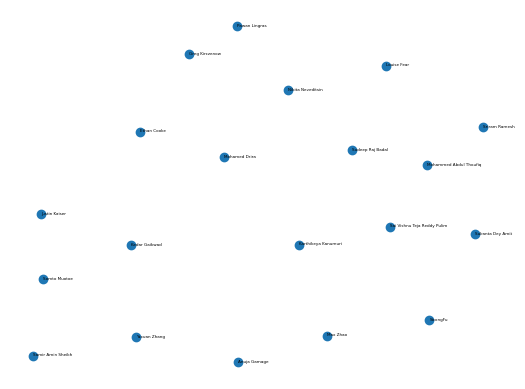

In [40]:
# Creating lists of coordinates with accompanying labels
x = [row[0] for row in reduced_data]
y = [row[1] for row in reduced_data]
label = list(person_embeddings.keys())

# Plotting and annotating data points
plt.scatter(x,y)
for i, name in enumerate(label):
    plt.annotate(name, (x[i], y[i]), fontsize="3")

# Clean-up and Export
plt.axis('off')
plt.savefig(project_path+'visualization.png', dpi=800)

## Find the  top N matches to a node

In [35]:
# Providing top matches
top_matches = {}
all_personal_pairs = defaultdict(list)
for person in attendees_map.values():
    for person1 in attendees_map.values():
        all_personal_pairs[person].append([spatial.distance.cosine(person_embeddings[person1], person_embeddings[person]), person1])

n = 5
# Collect the top n most similarity nodes
data_day_list = []
for person in attendees_map.values():
    top_matches[person] = sorted(all_personal_pairs[person], key=lambda x: x[0])[1:n+1] # drop yourself, take top 5
    a = sorted(all_personal_pairs[person], key=lambda x: x[0])[1:n+1]
    mini_df = pd.DataFrame(a, columns=['Weight', 'Target'])
    mini_df['Source'] = person
    data_day_list.append(mini_df)

top_matches_serializable = {
    person: [[np.float64(weight), target] for weight, target in matches]
    for person, matches in top_matches.items()
}

# output this information as a json
with open(project_path + 'b_top5_matches.json', 'w') as json_file:
    json.dump(top_matches_serializable, json_file)

# Output this information as a csv
df = pd.concat(data_day_list)
df.to_csv(project_path + 'b_top5_matches.csv')


## Add Colour/Paragraph Information to Dataframe

In [36]:
# Get the colour pallette
colour = sns.color_palette("pastel",len(x)).as_hex()

# Add colour pallette to the df
df1 = pd.DataFrame([label,colour])
df1 = df1.T
df1.rename(columns={0: 'Source', 1: 'Colour'},inplace=True)
df = df.set_index('Source').join(df1.set_index('Source'))
df['Source'] = df.index
df = df.reset_index(drop=True)

# Add colour pallette for both the df Target and Source:
df1.rename(columns={'Source': 'Target'},inplace=True)
df = df.set_index('Target').join(df1.set_index('Target'),lsuffix='_Source', rsuffix='_Target')
df['Target'] = df.index
df = df.reset_index(drop=True)
print(df)

# Add paragraphs to the df
df2 = pd.DataFrame([label,paragraphs])
df2 = df2.T
df2.rename(columns={0: 'Source', 1: 'Paragraphs'},inplace=True)
df = df.set_index('Source').join(df2.set_index('Source'))
df['Source'] = df.index
df = df.reset_index(drop=True)
print(df)

# Create a cleaned Dataframe of just the Source and and Paragraph information
df_new = df[["Source","Paragraphs"]]
df_new = df_new.drop_duplicates()
df_new.set_index('Source', inplace=True)

      Weight Colour_Source             Source Colour_Target             Target
0   0.464883       #a1c9f4     Greg Kirczenow       #8de5a1      Pawan Lingras
1   0.619713       #a1c9f4     Greg Kirczenow       #ffb482  Nikita Neveditsin
2   0.647434       #a1c9f4     Greg Kirczenow       #debb9b        Ethan Cooke
3   0.676570       #a1c9f4     Greg Kirczenow       #d0bbff        Louise Fear
4   0.677993       #a1c9f4     Greg Kirczenow       #ff9f9b           SicongFu
..       ...           ...                ...           ...                ...
95  0.351552       #b9f2f0  Samir Amin Sheikh       #ff9f9b       Somto Muotoe
96  0.429377       #b9f2f0  Samir Amin Sheikh       #fab0e4      Kedar Gaikwad
97  0.500486       #b9f2f0  Samir Amin Sheikh       #cfcfcf       Anuja Gamage
98  0.504239       #b9f2f0  Samir Amin Sheikh       #fffea3       Yaxuan Zhang
99  0.513427       #b9f2f0  Samir Amin Sheikh       #debb9b   Sukanta Dey Amit

[100 rows x 5 columns]
      Weight Colour_Source C

## Build Interative Network Visualization (Simple)

In [38]:
# Intitalize bucket size and colour palettes
buckets = [100] * len(x)
colour = sns.color_palette("pastel",len(x)).as_hex()

# Initialize network
g = Network(height="750px", width="100%", bgcolor="#222222", font_color="white")

# Add unconnected nodes to the network
g.add_nodes(list(range(1,len(x)+1)), value=buckets,
                         title=paragraphs,
                         x=np.array(x).astype(np.float64),
                         y=np.array(y).astype(np.float64),
                         label=label,
                         color=colour)

# Output the visualization
g.toggle_physics(True)
g.show(project_path+'c_simple_viz.html', notebook=False)

S:\5512\matchmaking-embeddings\c_simple_viz.html


## Build Interative Network Visualization (Complex)


In [39]:
# Initialize network
got_net = Network(height="750px", width="100%", bgcolor="#222222", font_color="white",select_menu=True,cdn_resources='remote')

# Create a dictionary of Important information
sources = df['Source']
targets = df['Target']
weights = df['Weight']
color_targets = df['Colour_Target']
color_sources = df['Colour_Source']

edge_data = zip(sources, targets, weights,color_targets,color_sources)

# Add nodes and edges to the network
for e in edge_data:
                src = e[0]
                dst = e[1]
                w = e[2]
                c_t= e[3]
                c_s= e[4]
                got_net.add_node(src, src, title=src,color=c_s)
                got_net.add_node(dst, dst, title=dst)
                got_net.add_edge(src, dst, value=w)#,color = "#c79910") # if you  want a solide colour for edges

# Add paragraphs to the popup
for i,node in enumerate(got_net.nodes):
               content =df_new.loc[node.get("title"),"Paragraphs"]
               node["title"] += ": "+ "\n \n" +'\n'.join(wrap(content, width=50))

## Output the visualization
got_net.show(project_path+'c_complex_viz.html', notebook=False)

S:\5512\matchmaking-embeddings\c_complex_viz.html
